## 2. Análisis de Sentimiento

Implementación y evaluación de un modelo de análisis de sentimiento.

El objetivo principal es el de realizar un **modelo de clasificación binaria**. Se valorará positivamente comparar la variación en los resultados al usar **diferentes modelos**, al **modificar algún paso en la etapa de preprocesado** (stemming vs no stemming, p.ej.), así como la comparación de resultados utilizando o bien **modelos pre-entrenados** o modelos más simples (como VADER).

Se utilizará alguno de los datasets disponibles de **reviews de Amazon**.

Soluciones más avanzadas como por ejemplo modelos de clasificación multi-clase o basados en embeddings serán valorables.

In [1]:
# Importamos lo que vayamos a necesitar
import pandas as pd
import numpy as np
import string
import random

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

from collections import Counter
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from nltk.stem.snowball import EnglishStemmer

# Nuestras funciones del archivo utils, para el procesado del texto
from utils import file_to_dict, process_text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


from multiprocessing.pool import Pool
from functools import partial
from os import cpu_count

import seaborn as sns

/home/alberto/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/home/alberto/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/home/alberto/anaconda3/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


### 1. Importamos y procesamos nuestros datos

In [2]:
data = pd.read_csv('./datasets/reviews.csv')

In [3]:
data['rating_binary_label'] = data['rating'].apply(lambda it: 'pos' if it > 3 else 'neg')

In [4]:
data['rating_triary_label'] = data['rating'].apply(lambda it: 'pos' if it > 3 else ('neu' if it == 3 else 'neg'))

In [5]:
# Vemos que ha creado nuestra neuva columna
data.head()

,review,rating,helpful,category,rating_binary_label,rating_triary_label
0,A fun way to bling up your desk and make sure ...,4,1.0,Office products,pos,pos
1,I continue to love this show. Raylan and the r...,5,0.0,Amazon instant videos,pos,pos
2,Arrived in super flash time. Like another rev...,5,0.0,Patio lawn/garden,pos,pos
3,This treat ball works as expected. I used Temp...,4,0.5,Pet supplies,pos,pos
4,I know it's extrange but it works! It is easy ...,4,0.0,Baby,pos,pos


In [6]:
# Constants
lemas = file_to_dict('./datasets/lemmatization-en.txt')
min_length = 50
en_stop_words = gensim.parsing.preprocessing.STOPWORDS
translate_table = dict((ord(char), None) for char in string.punctuation)  
lang='en'
stemmer = EnglishStemmer(ignore_stopwords=True)

In [7]:
def process_row(row):    
    if type(row['review']) is str:    
        aux = process_text(min_length, lemas, translate_table, en_stop_words, 'en', stemmer, row['review'])
        if aux:
            return {
                'original_review': row['review'],
                'review': ' '.join(aux),
                'review_processed': aux,
                'category': row['category'],
                'rating_binary_label': row['rating_binary_label'],
                'rating_triary_label': row['rating_triary_label']
            }

In [8]:
pool = Pool(cpu_count())
df = [it for it in pool.map(process_row, [row for index, row in data.iterrows()]) if it]
pool.close()
df = pd.DataFrame(list(df))
df.dropna(inplace=True)

In [9]:
df

,original_review,review,review_processed,category,rating_binary_label,rating_triary_label
0,A fun way to bling up your desk and make sure ...,bling desk surest want stolen stapler return i...,"[bling, desk, surest, want, stolen, stapler, r...",Office products,pos,pos
1,I continue to love this show. Raylan and the r...,continu love raylan rest charact southern atmo...,"[continu, love, raylan, rest, charact, souther...",Amazon instant videos,pos,pos
2,Arrived in super flash time. Like another rev...,arriv super flash time like anoth review hard ...,"[arriv, super, flash, time, like, anoth, revie...",Patio lawn/garden,pos,pos
3,This treat ball works as expected. I used Temp...,treat ball work expect tempat treat dispens fi...,"[treat, ball, work, expect, tempat, treat, dis...",Pet supplies,pos,pos
4,I know it's extrange but it works! It is easy ...,know extrang works easiest clean eighth month ...,"[know, extrang, works, easiest, clean, eighth,...",Baby,pos,pos
...,...,...,...,...,...,...
177120,I have been using these for about 2 years now;...,second year happiest strap lock great product,"[second, year, happiest, strap, lock, great, p...",Musical instruments,pos,pos
177121,This unit does everything it says it does. I e...,unit everyth friend dodg intrepid told exact w...,"[unit, everyth, friend, dodg, intrepid, told, ...",Automotive,pos,pos
177122,"For years, I had been using Smead hanging fold...",year smead hang folder plastic remov rarest oc...,"[year, smead, hang, folder, plastic, remov, ra...",Office products,pos,pos
177123,Pros:- You don't need to touch the dead rat- L...,pros need touch dead look cons silver scary ha...,"[pros, need, touch, dead, look, cons, silver, ...",Patio lawn/garden,neg,neu


## Separamos en train test

In [10]:
def train_test_splt(values, labels):
    print('Spliting...')
    return train_test_split(
        values,
        labels,
        train_size=0.75,
        test_size=0.25,
        random_state=42,
        shuffle=True,
        stratify=labels
    )

In [11]:
X_train, X_test, y_train, y_test = train_test_splt(df['review'], df['rating_binary_label'])
X_train, X_validation, y_train, y_validation= train_test_splt(X_train, y_train)

Spliting...
Spliting...


## Extraccion de caracteristicas

In [12]:
def plot_chi_square(values, labels, words_to_show=10): 
    # Compute the chi-squared score for each word in the training set and show the values
    chi2score = chi2(values, labels)[0]
    scores = list(zip(cv.get_feature_names(), chi2score))
    sorted_scores = sorted(scores, key=lambda x:x[1])
    topchi2 = list(zip(*sorted_scores[-words_to_show:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]

    plt.figure(figsize=(12, 8))
    plt.barh(x,topchi2[1], align='center', alpha=0.5)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels, fontsize=12)
    plt.xlabel(r'$\chi^2$', fontsize=26)
    plt.ylabel('word', fontsize=16)
    plt.title(r'Top {} $\chi^2$ score for each word in the training set'.format(words_to_show), fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.show();

In [13]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1,2)
)
cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_validation_ = cv.transform(X_validation)
X_test_ = cv.transform(X_test)

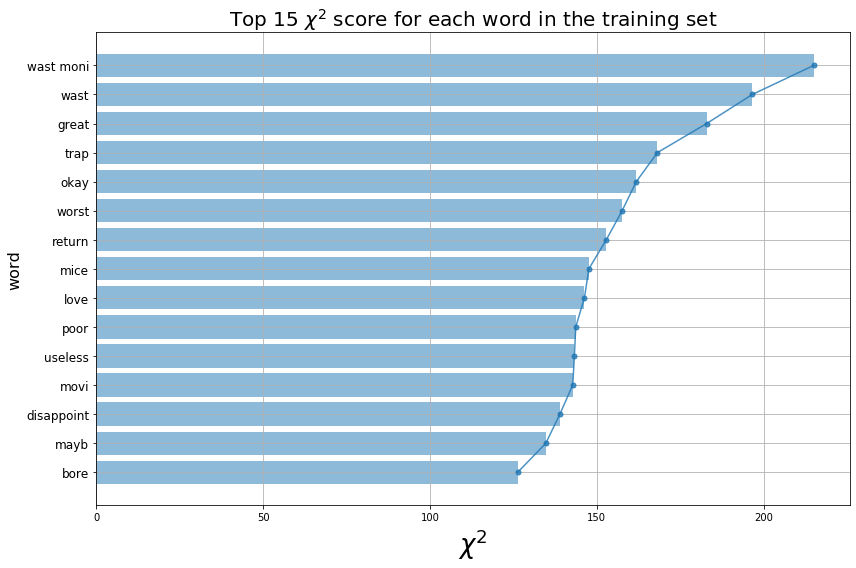

In [14]:
plot_chi_square(X_train_, y_train, 15)

## Evaluacion del modelo

In [15]:
def evaluation(model, values, labels):
    test_predict = model.predict(values)
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

In [16]:
def plot_values(values, max_idx, labels):
    plt.figure(figsize=(12, 8))
    for d in values:
        plt.plot(d.get('value'), label=d.get('label'))
    plt.axvline(max_idx, c='g', ls='--', alpha=0.8)
    plt.title('Accuracy evolution for different C values')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.xticks(list(range(len(labels))), labels)
    plt.tight_layout()
    plt.show()

In [17]:
def dict_creator(model, tp, vp, tacc, vacc): 
    return {
        'model': model,
        'predictions': {
            'train': tp,
            'validation': vp
        },
        'accuracy': {
            'train': tacc,
            'validation': vacc
        }
    }

In [18]:
def grid_executor(c_params, solvers, max_iter, X_train, y_train, X_val, y_val, multiple_label=False):

    # preparamos las eituqetas si va a ser multi-salida
    if multiple_label:
        y_train = y_train.values.reshape(-1,1)
    
    res = []
    for solver in solvers:
        for c in c_params:        
            print(f'Evaluating model with C={c}, solver={solver}, max_iter={max_iter}')
            model = LogisticRegression(C=c, solver=solver, max_iter=max_iter)
            
            if multiple_label:
#                 model.multi_class = 'ovr'
                model = MultiOutputRegressor(model)     
            
            model.fit(X_train_, y_train)

            train_predict = model.predict(X_train_)
            validation_predict = model.predict(X_validation_)
            
            train_acc = accuracy_score(y_train, train_predict)
            validation_acc = accuracy_score(y_val, validation_predict)

            print (f"Accuracy train: {train_acc}, val: {validation_acc}")
            
            res.append(dict_creator(model, train_predict, validation_predict, train_acc, validation_acc))
    return res

In [19]:
def plot_accuracy_evolution(grid):
    train_acc = []
    val_acc = []
    for aux in grid:
        train,val = aux.get('accuracy').values()
        train_acc.append(train)
        val_acc.append(val)

    values = [
        {'label': 'train', 'value': train_acc},
        {'label': 'validation', 'value': val_acc}
    ]

    optimal_model_idx = np.argmax(val_acc)

    plot_values(values, optimal_model_idx, c_params)
    
    return optimal_model_idx

In [20]:


c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000, 20000]
solvers  = ['lbfgs']
max_iter = 800

grid = grid_executor(c_params, solvers, max_iter, X_train_, y_train, X_validation_, y_validation)


Evaluating model with C=0.01, solver=lbfgs, max_iter=800
Accuracy train: 0.8325839087843263, val: 0.8325855891120412
Evaluating model with C=0.05, solver=lbfgs, max_iter=800
Accuracy train: 0.8404930142925967, val: 0.8401132155008882
Evaluating model with C=0.25, solver=lbfgs, max_iter=800
Accuracy train: 0.8644712542155131, val: 0.8597151546174461
Evaluating model with C=0.5, solver=lbfgs, max_iter=800
Accuracy train: 0.8704633049622611, val: 0.864291951461865
Evaluating model with C=1, solver=lbfgs, max_iter=800
Accuracy train: 0.8741167496386703, val: 0.8663394658396314
Evaluating model with C=10, solver=lbfgs, max_iter=800
Accuracy train: 0.8783924843423799, val: 0.8674535545451808
Evaluating model with C=100, solver=lbfgs, max_iter=800
Accuracy train: 0.8788140356511964, val: 0.8673030020174038
Evaluating model with C=1000, solver=lbfgs, max_iter=800
Accuracy train: 0.8790348482415288, val: 0.8673331125229593
Evaluating model with C=10000, solver=lbfgs, max_iter=800
Accuracy train

/home/alberto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy train: 0.8790549221133772, val: 0.8674535545451808


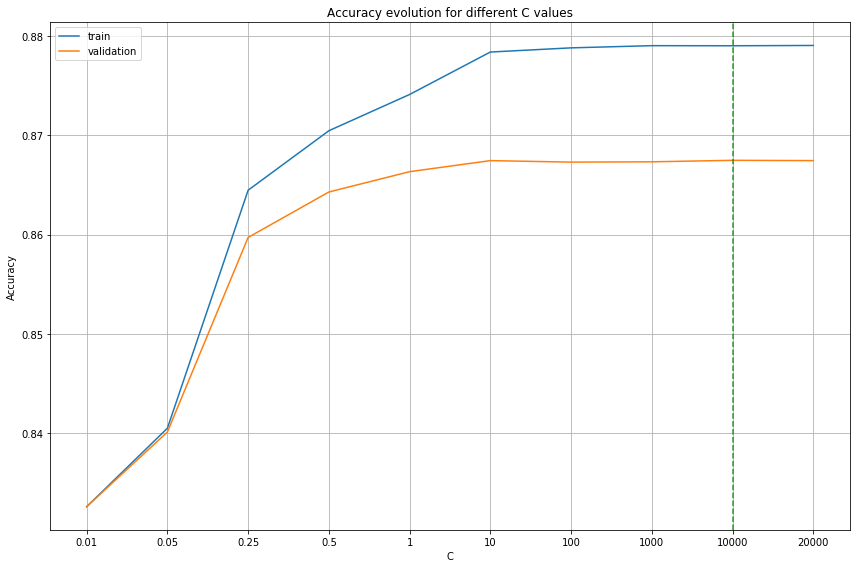

In [21]:
optimal_model_idx = plot_accuracy_evolution(grid)

In [22]:
evaluation(grid[optimal_model_idx].get('model'), X_test_, y_test)

Confussion matrix:
[[ 3151  4263]
 [ 1532 35336]]

Classification report:
              precision    recall  f1-score   support

         neg       0.67      0.43      0.52      7414
         pos       0.89      0.96      0.92     36868

    accuracy                           0.87     44282
   macro avg       0.78      0.69      0.72     44282
weighted avg       0.86      0.87      0.86     44282

Accuracy score:0.8691341854478117


## Comprobamos nuestro modelo

In [23]:
CRED = '\033[41m'
CGREEN = '\033[42m'
CEND = '\033[0m'

In [24]:
def predict_review_sentiment(model, cv, reviews, labels, num_samples, multi=False):
    predictions = []
    lbls = []
    for i in range(num_samples):
        index = random.choice(X_test.index)
        r = reviews[index]
        
        prediction = model.predict(cv.transform([r]))[0]
        if multi:
            prediction = prediction[0]
        
        predictions.append(prediction)
        lbls.append(labels[index])
        
        color = (CRED, CGREEN)[labels[index] == prediction]
        print(f"Comprobando review {index}")
        print(f"{color}Sentimiento {labels[index]} - {prediction}{CEND}")
    print('Accuracy scorede los elementos de prueba: {}'.format(accuracy_score(lbls, predictions)))

In [27]:
predict_review_sentiment(grid[optimal_model_idx].get('model'), cv, X_test, y_test, 10)

Comprobando review 138397
Sentimiento pos - pos
Comprobando review 123912
Sentimiento pos - pos
Comprobando review 61533
Sentimiento pos - pos
Comprobando review 63569
Sentimiento pos - pos
Comprobando review 140195
Sentimiento neg - neg
Comprobando review 61358
Sentimiento pos - neg
Comprobando review 121199
Sentimiento pos - pos
Comprobando review 18062
Sentimiento pos - pos
Comprobando review 121578
Sentimiento pos - pos
Comprobando review 144760
Sentimiento pos - pos
Accuracy scorede los elementos de prueba: 0.9


Como vemos la moyoria de preducciones con correctas, el menos podemos afirmar eso para unas etiquetas binarias, vamos a probar ahora con 3 'sentimientos'

## Vamos a probar ahora con VADER


Dado que `VADER` ya esta preentrenado vamos a probar con unas `reviews` al azar, del dataset original, y comprobaremos como se comporta respecto al texto original con el texto procesado en comparacon con la etiqueta que se le ha asignado en funcion del valor de 'estrellas'.

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [29]:
def sentiment_analyzer_scores(df, num_samples):
    
    for i in range(num_samples):
        index = random.choice(df.index)
        original_review = df['original_review'][index]
        processed_review = df['review'][index]
        
        original_score = analyser.polarity_scores(original_review)
        processed_score = analyser.polarity_scores(processed_review)
        
        print(f'REVIEW {index}')
        print('Original review')
        print(original_review)
        print('Processed review')
        print(processed_review)
        print()
        print(f'Original score {df["rating_triary_label"][index]}')
        print(original_score)
        print(processed_score)
        print()

In [30]:
sentiment_analyzer_scores(df, 1)

REVIEW 122436
Original review
I have been on the Tegan and Sara bandwagon since I started listening to them around the time of their excellent 2004 "So Jealous" album (still my favorite ablum of their to this day). 2007's "The Con" album was quite good too, but didn't quite bring the same enjoyment for me. Now comes the new album (ok, this was released in October, but I'm still catching up on some 2009 releases I never got around to fully exploring).WIth the opening sounds of "Sainthood" (13 tracks; 37 min.) on the opener "Arrow", it immediately feels like this album has an urgency that "The Con" never seemed to have. First single "Hell" is an irresitable pop song outright (reminding me of Metric, for one thing). "The Cure" is another single in the waiting. "Alligator" (second single) is another great tune, albeit not the attention-grabber that "Hell" or "The Cure" is, in my opinion. "Northshore" is almost a punk-like anthem (quite a long way off from their folksy-guitar beginnings). T

Para proba eso se puede altear el parametro `num_samples`.

Viendo los reultados que aroja, se puede 'asumir' que mas o menos los resultados que ofrece VADER, se ajustan bastante tanto para el texto original como para el texto procesado.

En la mayoria de casos se observa que da como resultado neutral

Ahora vamos a comprobar las predicciones de VADER para el conjunto de test frente a las que da nuestro algoritmo

In [31]:
def score_to_tag(d, tags=['pos', 'neg']):
    return tags[np.argmax([d[tag] for tag in tags])] 

In [57]:
def plot_correlation_matrix(original, predictiosn, vader_predictions, tags=['pos', 'neg']):
    df_aux = pd.DataFrame({'original': original,'predictions': predictions, 'vader_predictions': vader_predictions})  
    
    le = LabelEncoder()
    le.fit(tags)
    df_aux['original'] = le.transform(df_aux['original'])
    df_aux['predictions'] = le.transform(df_aux['predictions'])
    df_aux['vader_predictions'] = le.transform(df_aux['vader_predictions'])

    correlation_mat = df_aux.corr()
    sns.heatmap(correlation_mat, annot = True)
    plt.show()

In [33]:
predictions = []
vader_predictions = []

for it in X_test:
    vader_predictions.append(score_to_tag(analyser.polarity_scores(it)))
    predictions.append(grid[optimal_model_idx].get('model').predict(cv.transform([it]))[0])


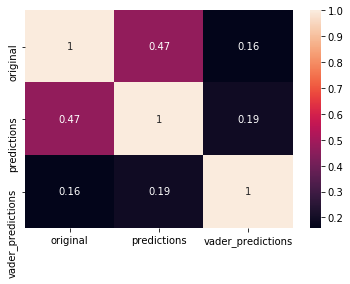

In [34]:
plot_correlation_matrix(y_test, predictions, vader_predictions)

Observamos aqui la matriz de correlacion, en la que comparamos los datos 'originales' con las predicciones de nuestro modelo con las de VADER. Como resultado se distingue una mayor aproximacion con el primero ya que todo parte de nuestros datos y no de unos preentrenados.

## Evaluacion para 3 etiquetas

In [35]:
X_train, X_test, y_train, y_test = train_test_splt(df['review'], df['rating_triary_label'])
X_train, X_validation, y_train, y_validation= train_test_splt(X_train, y_train)

Spliting...
Spliting...


In [36]:
cv_multi = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1,2)
)
cv_multi.fit(X_train)

X_train_ = cv_multi.transform(X_train)
X_validation_ = cv_multi.transform(X_validation)
X_test_ = cv_multi.transform(X_test)

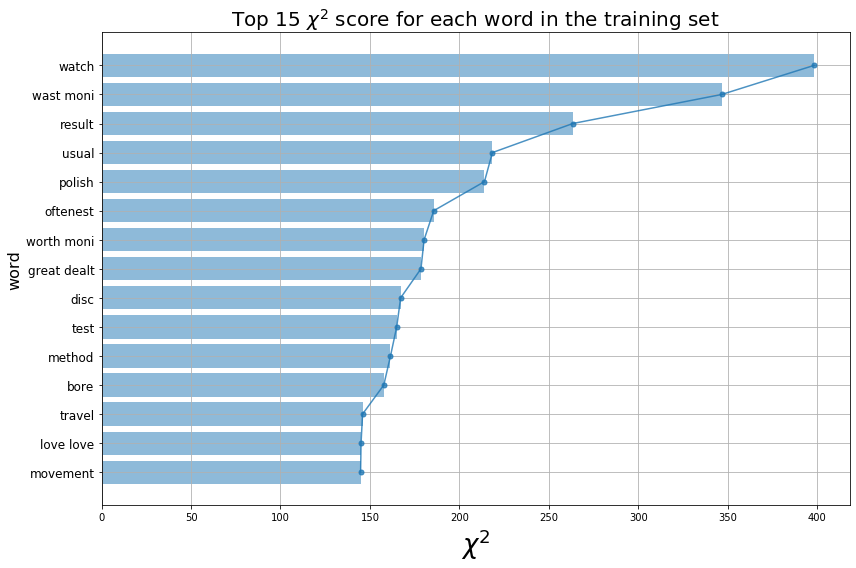

In [37]:
plot_chi_square(X_train_, y_train, 15)

In [38]:

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100]
solvers  = ['lbfgs']
max_iter = 1200

grid_multi = grid_executor(c_params, solvers, max_iter, X_train_, y_train, X_validation_, y_validation, True)

Evaluating model with C=0.01, solver=lbfgs, max_iter=1200
Accuracy train: 0.8325738718484021, val: 0.8325855891120412
Evaluating model with C=0.05, solver=lbfgs, max_iter=1200
Accuracy train: 0.8374217118997912, val: 0.8367709493842401
Evaluating model with C=0.25, solver=lbfgs, max_iter=1200
Accuracy train: 0.8537016219688454, val: 0.8479419469452892
Evaluating model with C=0.5, solver=lbfgs, max_iter=1200
Accuracy train: 0.858429018789144, val: 0.851645539128602
Evaluating model with C=1, solver=lbfgs, max_iter=1200
Accuracy train: 0.8621426850810985, val: 0.8526090753063744
Evaluating model with C=10, solver=lbfgs, max_iter=1200
Accuracy train: 0.8671410791713505, val: 0.8539640480563668
Evaluating model with C=100, solver=lbfgs, max_iter=1200
Accuracy train: 0.8674221133772282, val: 0.853271506428593


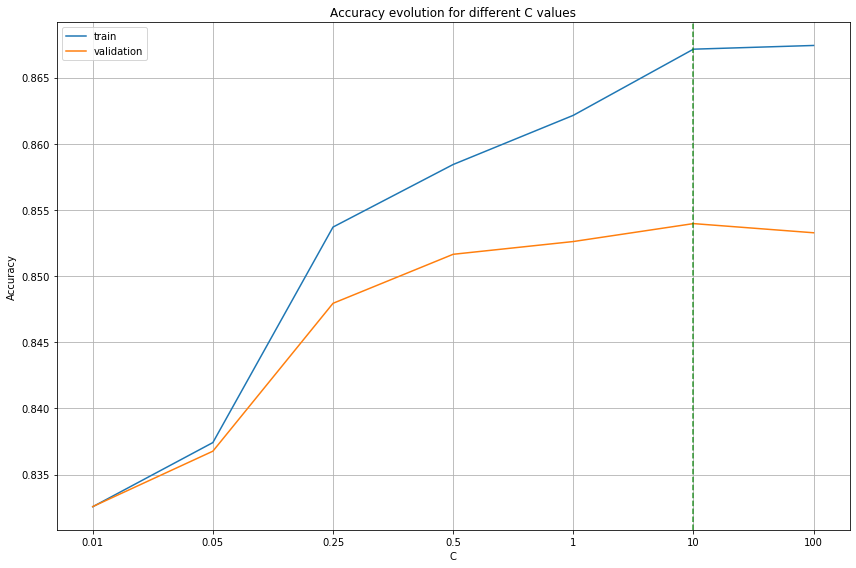

In [41]:
optimal_model_idx = plot_accuracy_evolution(grid_multi)
optimal_model = grid_multi[optimal_model_idx].get('model')

In [42]:
evaluation(optimal_model, X_test_, y_test)

Confussion matrix:
[[ 1252   253  1759]
 [  358   745  3046]
 [  476   517 35876]]

Classification report:
              precision    recall  f1-score   support

         neg       0.60      0.38      0.47      3264
         neu       0.49      0.18      0.26      4149
         pos       0.88      0.97      0.93     36869

    accuracy                           0.86     44282
   macro avg       0.66      0.51      0.55     44282
weighted avg       0.82      0.86      0.83     44282

Accuracy score:0.8552685063908586


In [44]:
predict_review_sentiment(optimal_model, cv_multi, X_test, y_test, 10, multi=True)

Comprobando review 9970
Sentimiento neu - pos
Comprobando review 21987
Sentimiento pos - pos
Comprobando review 108455
Sentimiento pos - pos
Comprobando review 79918
Sentimiento pos - pos
Comprobando review 105219
Sentimiento pos - pos
Comprobando review 151425
Sentimiento neg - neg
Comprobando review 41098
Sentimiento pos - pos
Comprobando review 3916
Sentimiento neg - neg
Comprobando review 68280
Sentimiento neg - pos
Comprobando review 102502
Sentimiento pos - pos
Accuracy scorede los elementos de prueba: 0.8


Vamos a probar ahora VADER para las 3 etiquetas

In [54]:
predictions = []
vader_predictions = []

for it in X_test:
    vader_predictions.append(
        score_to_tag(analyser.polarity_scores(it), ['pos', 'neu', 'neg'])
    )
    predictions.append(optimal_model.predict(cv.transform([it]))[0][0])


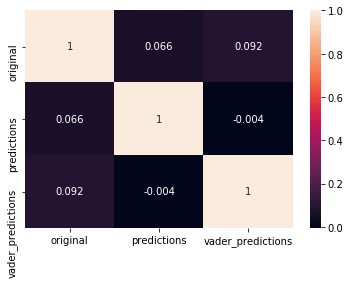

In [58]:
plot_correlation_matrix(y_test, predictions, vader_predictions, ['pos', 'neu', 'neg'])

En este caso vemo que la comparacion entre las predicciones de nuestro modelo y las de VADER son bastente dispares, ya que para este ultimo la mayoria de elementos son neutros (o por lo menos en nuestro caso).

En cuando a las originales vemos que hay mayor acierto con las de VADER que con las de nuestro algoritmo.